In [1]:
    # Load packages for (ADV_analytics kernel)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

%matplotlib inline
print("All packages are available!")

All packages are available!


Notes: 

1.  1 blank 'party_detailed' vote cast for Donald TRUMP, corrected party to REPUBLICAN pior to import.  

2.  Remaining blanks verified as writein votes cast for "OTHER" party candidates.

3.  94 samples labeled "DEMOCRAT/REPUBLICAN" in 'party_detailed':  
    utilized PA.gov to confirm HEFFLEY = REPUBLICAN, LONGIETTI = DEMOCRAT.

4.  In Nov 2020, there were four recognized political parties in Pennsylvania.  
    Democratic Party, Green Party, Libertarian Party, Republican Party.  
    DEM and REP votes accounted for 96% of total votes; "OTHER" will combine any vote for another.   

In [144]:
    # Import the first dataset
VTD_import = pd.read_csv('PA_l2_turnout_stats_block20.csv')
#print(VTD_import.head())

FileNotFoundError: [Errno 2] No such file or directory: 'PA_l2_turnout_stats_block20.csv'

In [ ]:
    # Inspect VTD file
    # Retain only GEOID and 03NOV2020 columns
vtd_columns = ['geoid20',
    'g20201103_reg_all', 'g20201103_voted_all', 'g20201103_pct_voted_all',
    'g20201103_reg_eur', 'g20201103_voted_eur', 'g20201103_pct_voted_eur',
    'g20201103_reg_hisp', 'g20201103_voted_hisp', 'g20201103_pct_voted_hisp',
    'g20201103_reg_aa', 'g20201103_voted_aa', 'g20201103_pct_voted_aa',
    'g20201103_reg_esa', 'g20201103_voted_esa', 'g20201103_pct_voted_esa',
    'g20201103_reg_oth', 'g20201103_voted_oth', 'g20201103_pct_voted_oth',
    'g20201103_reg_unk', 'g20201103_voted_unk', 'g20201103_pct_voted_unk']

    # Change VAR names
VTD_inspect = (VTD_import[vtd_columns]
               .rename(columns=lambda x: x.replace('g20201103_', ''))
               .rename(columns=lambda x: x.replace('pct_voted', 'turnout'))
               .rename(columns=lambda x: x.replace('_esa', '_asia'))
               .copy())

    # Create 'GEOID' column and truncate, drop original
VTD_inspect['GEOID'] = VTD_inspect['geoid20'].astype(str).str[:11]
VTD_inspect = VTD_inspect.drop(columns=['geoid20'])
                               
    # Confirm
#print(VTD_inspect.info())

In [ ]:
    # Define aggregation rules
    # Use sum for all columns that do not contain 'turnout' (excluding GEOID)
sum_cols = [col for col in VTD_inspect.columns if 'turnout' not in col and col != 'GEOID']
    # Use mean for columns containing 'turnout'
mean_cols = [col for col in VTD_inspect.columns if 'turnout' in col]

    # Group by GEOID and aggregate
VTD_transform = VTD_inspect.groupby('GEOID').agg({
    **{col: 'sum' for col in sum_cols}, 
    **{col: 'mean' for col in mean_cols}}).reset_index()

    # Convert 'reg_' and 'voted_' columns to int32
convert_cols = [col for col in VTD_transform.columns if 
                col.startswith('reg_') or col.startswith('voted_')]
VTD_transform[convert_cols] = VTD_transform[convert_cols].astype('int32')

   # Confirm
#print(VTD_transform.info())
#print(VTD_transform['GEOID'].value_counts())

In [ ]:
    # Create "turnout_gap" for each group (turnout_grp - turnout_all)
base_cols = ['all', 'eur', 'hisp', 'aa', 'asia', 'oth', 'unk']
for grp in base_cols:
   col_name = f'turnout_{grp}'
   VTD_transform[col_name] = (VTD_transform[col_name] * 100).round(2)
for grp in base_cols[1:]:
   VTD_transform[f'turnout_{grp}'] = VTD_transform[
   f'turnout_{grp}'] - VTD_transform['turnout_all']

    # Define column order, No turnout_gap for 'all'
final_cols = ['GEOID']
for grp in base_cols:
   final_cols.extend([f'reg_{grp}', f'voted_{grp}', f'turnout_{grp}'])
   if grp != 'all':
        final_cols.append(f'turnout_gap_{grp}')

    # Reorder
VTD_tidy = VTD_transform[final_cols]
VTD_tidy['GEOID-5'] = VTD_tidy['GEOID'].astype(str).str[:5]

    # Confirm final tidy dataframe
#print(VTD_tidy.info())
#print(VTD_tidy.head())
#VTD_tidy.shape

In [ ]:
#VTD_tidy.to_excel('VTD_tidy.xlsx', index=False)

In [84]:
    # Import and tidy DHC dataset
DHC_import = pd.read_csv('pa_dhc_2020_t.csv')
#print(DHC_import.head())

In [86]:
    # Format GEOID: rename and truncate
DHC_inspect = DHC_import.rename(columns={'GEOID20': 'GEOID'})
DHC_inspect['GEOID'] = DHC_inspect['GEOID'].astype(str).str[:11]

    # Drop columns with constant entries or conflicts (County = COUNTYFP20 = GEOID)
DHC_inspect = DHC_inspect.drop(columns=[
    'STATEFP20', 'STATE', 'COUNTYFP20', 'COUNTY', 'NOT_DEF'])

    # Confirm
#print(DHC_inspect.info())
#print(DHC_inspect['GEOID'].value_counts())

In [88]:
    # Remove any record where total pop = 0, to prevent NAs in ratios
DHC_transform = DHC_inspect[(DHC_inspect['TOT_POP'] != 0) & (
                            DHC_inspect['HH_IN_HH'] != 0)].copy()

    # Compute new ratios for basic population metrics
DHC_transform['URBAN_RATIO']  = (DHC_transform['URBAN'] / DHC_transform['TOT_POP'] * 100).round(2)
DHC_transform['RURAL_RATIO']  = (DHC_transform['RURAL'] / DHC_transform['TOT_POP'] * 100).round(2)
DHC_transform['MALE_RATIO']   = (DHC_transform['MALE'] / DHC_transform['TOT_POP'] * 100).round(2)
DHC_transform['FEMALE_RATIO'] = (DHC_transform['FEMALE'] / DHC_transform['TOT_POP'] * 100).round(2)

    # Compute new age groups
DHC_transform['F_U18']    = DHC_transform['U5_F'] + DHC_transform['5_9_F'] + \
        DHC_transform['10_14_F'] + DHC_transform['15_17_F']
DHC_transform['F_18-20s'] = DHC_transform['18_19_F'] + DHC_transform['20_F']
DHC_transform['F_30s']    = DHC_transform['30_34_F'] + DHC_transform['35_39_F']
DHC_transform['F_40s']    = DHC_transform['40_44_F'] + DHC_transform['45_49_F']
DHC_transform['F_50s']    = DHC_transform['50_54_F'] + DHC_transform['55_59_F']
DHC_transform['F_60up']    = (DHC_transform['60_61_F'] + DHC_transform['62_64_F'] + \
        DHC_transform['65_66_F'] + DHC_transform['67_69_F'] + DHC_transform['70_74_F'] + \
        DHC_transform['75_79_F'] + DHC_transform['80_84_F'] + DHC_transform['85_O_F'])
DHC_transform['M_U18']    = DHC_transform['U5_M'] + DHC_transform['5_9_M'] + \
        DHC_transform['10_14_M'] + DHC_transform['15_17_M']
DHC_transform['M_18-20s'] = DHC_transform['18_19_M'] + DHC_transform['20_M']
DHC_transform['M_30s']    = DHC_transform['30_34_M'] + DHC_transform['35_39_M']
DHC_transform['M_40s']    = DHC_transform['40_44_M'] + DHC_transform['45_49_M']
DHC_transform['M_50s']    = DHC_transform['50_54_M'] + DHC_transform['55_59_M']
DHC_transform['M_60up']    = (DHC_transform['60_61_M'] + DHC_transform['62_64_M'] + \
        DHC_transform['65_66_M'] + DHC_transform['67_69_M'] + DHC_transform['70_74_M'] + \
        DHC_transform['75_79_M'] + DHC_transform['80_84_M'] + DHC_transform['85_O_M'])

    # Compute ratios for the new age groups (relative to total FEMALE or MALE)
DHC_transform['F_U18_RATIO']    = (DHC_transform['F_U18']    / DHC_transform['TOT_POP'] * 100).round(2)
DHC_transform['F_18-20s_RATIO'] = (DHC_transform['F_18-20s'] / DHC_transform['TOT_POP'] * 100).round(2)
DHC_transform['F_30s_RATIO']    = (DHC_transform['F_30s']    / DHC_transform['TOT_POP'] * 100).round(2)
DHC_transform['F_40s_RATIO']    = (DHC_transform['F_40s']    / DHC_transform['TOT_POP'] * 100).round(2)
DHC_transform['F_50s_RATIO']    = (DHC_transform['F_50s']    / DHC_transform['TOT_POP'] * 100).round(2)
DHC_transform['F_60up_RATIO']    = (DHC_transform['F_60up']    / DHC_transform['TOT_POP'] * 100).round(2)
DHC_transform['M_U18_RATIO']    = (DHC_transform['M_U18']    / DHC_transform['TOT_POP'] * 100).round(2)
DHC_transform['M_18-20s_RATIO'] = (DHC_transform['M_18-20s'] / DHC_transform['TOT_POP'] * 100).round(2)
DHC_transform['M_30s_RATIO']    = (DHC_transform['M_30s']    / DHC_transform['TOT_POP'] * 100).round(2)
DHC_transform['M_40s_RATIO']    = (DHC_transform['M_40s']    / DHC_transform['TOT_POP'] * 100).round(2)
DHC_transform['M_50s_RATIO']    = (DHC_transform['M_50s']    / DHC_transform['TOT_POP'] * 100).round(2)
DHC_transform['M_60up_RATIO']    = (DHC_transform['M_60up']    / DHC_transform['TOT_POP'] * 100).round(2)

    # Define new household groups sexuality will be considered
    # Marital status not considered, assuming relationship / marriage will have same outcome
DHC_transform['O_SEX_REL'] = DHC_transform['O_SEX_MAR'] + DHC_transform['O_SEX_UMAR']
DHC_transform['S_SEX_REL'] = DHC_transform['S_SEX_MAR'] + DHC_transform['S_SEX_UMAR']
    # "OTHER" = non-related (roommates) and persons in institution quarters
DHC_transform['OTHER_HH'] = DHC_transform['OTH_NONREL'] + DHC_transform['GRP_QUART']

    # --- Compute Ratios for housing groups
DHC_transform['F_SINGLE_RATIO'] = (DHC_transform['F_ALONE'] / DHC_transform['HH_IN_HH'] * 100).round(2)
DHC_transform['M_SINGLE_RATIO'] = (DHC_transform['M_ALONE'] / DHC_transform['HH_IN_HH'] * 100).round(2)
DHC_transform['F_LED_HH_RATIO'] = (DHC_transform['F_N_ALONE'] / DHC_transform['HH_IN_HH'] * 100).round(2)
DHC_transform['M_LED_HH_RATIO'] = (DHC_transform['M_N_ALONE'] / DHC_transform['HH_IN_HH'] * 100).round(2)
DHC_transform['OTH_HH_RATIO'] = (DHC_transform['OTHER_HH'] / DHC_transform['HH_IN_HH'] * 100).round(2)
DHC_transform['OPPSEX_RATIO'] = (DHC_transform['O_SEX_REL'] / DHC_transform['HH_IN_HH'] * 100).round(2)
DHC_transform['SAMESEX_RATIO'] = (DHC_transform['S_SEX_REL'] / DHC_transform['HH_IN_HH'] * 100).round(2)

    # Confirm
#pd.set_option('display.max_columns', None)
#print(DHC_transform.head(20))

In [90]:
    # Define final column order
final_cols = [
    'GEOID', 'TOT_POP', 
    'URBAN', 'URBAN_RATIO', 
    'RURAL', 'RURAL_RATIO', 
    'MED_AGE', 'MED_AGE_M', 'MED_AGE_F', 
    'F_U18', 'F_U18_RATIO', 'M_U18', 'M_U18_RATIO',  
    'F_18-20s', 'F_18-20s_RATIO', 'M_18-20s', 'M_18-20s_RATIO',  
    'F_30s', 'F_30s_RATIO', 'M_30s', 'M_30s_RATIO',  
    'F_40s', 'F_40s_RATIO', 'M_40s', 'M_40s_RATIO',  
    'F_50s', 'F_50s_RATIO', 'M_50s', 'M_50s_RATIO',  
    'F_60up', 'F_60up_RATIO', 'M_60up', 'M_60up_RATIO',  
    'MALE', 'MALE_RATIO', 'FEMALE', 'FEMALE_RATIO',  
    'F_ALONE', 'F_SINGLE_RATIO', 'M_ALONE', 'M_SINGLE_RATIO', 
    'F_N_ALONE', 'F_LED_HH_RATIO', 'M_N_ALONE', 'M_LED_HH_RATIO',
    'O_SEX_REL', 'OPPSEX_RATIO', 'S_SEX_REL', 'SAMESEX_RATIO', 
    'OTHER_HH', 'OTH_HH_RATIO', 'HH_IN_HH']
DHC_tidy = DHC_transform[final_cols]

    # Confirm
#print(DHC_tidy.info())
#DHC_tidy.shape

In [92]:
#DHC_tidy.to_excel('DHC_tidy.xlsx', index=False)

In [13]:
    # Import third dataset
MEDSL_import = pd.read_csv('pa_medsl_20_general.csv')

    # Inspect
#print(MEDSL_import.head())

FileNotFoundError: [Errno 2] No such file or directory: 'pa_medsl_20_general.csv'

In [22]:
    # Inspect MEDSL file
    # Retain only the needed columns
MEDSL_inspect = MEDSL_import[['office', 'county_fips', 'precinct',  
                            'party_detailed', 'votes']]

    # Rename columns
MEDSL_inspect = MEDSL_inspect.rename(columns={
    'county_fips': 'GEOID-5', 
    'party_detailed': 'PARTY', 
    'votes': 'VOTES'})

    # fix GEOID type
MEDSL_inspect['GEOID-5'] = MEDSL_inspect['GEOID-5'].astype(str)

    # Confirm
#print(MEDSL_inspect.info())
#print(MEDSL_inspect['office'].value_counts(dropna=False))

In [24]:
    # Keep single race to avoid counting multiple votes per person
MEDSL_clean = MEDSL_inspect[MEDSL_inspect['office'] == 'AUDITOR GENERAL'] 
MEDSL_clean = MEDSL_clean.copy().drop(columns=['office']) # closest vote total to VTD

    # Fill any missing values and change GREEN and LIBERTARIAN to 'OTHER' 
MEDSL_clean.loc[:, 'PARTY'] = MEDSL_clean['PARTY'].fillna('OTHER')
MEDSL_clean['PARTY'] = MEDSL_clean['PARTY'].replace({'GREEN': 'OTHER', 
                                                     'LIBERTARIAN': 'OTHER'})
    # Confirm
#print(MEDSL_clean.info())
#print(MEDSL_clean['PARTY'].value_counts(dropna=False))

In [26]:
    # Pivot PARTY to columns
MEDSL_transform1 = (MEDSL_clean.pivot_table(
        index=['precinct', 'GEOID-5'], 
        columns='PARTY', 
        values='VOTES', 
        aggfunc='sum')
    .reset_index()
    .fillna(0))    # Fill new NaN votes with 0

    # Confirm
#print(MEDSL_transform1.info())
#print(MEDSL_transform1.head(10))

In [28]:
    # Drop prefix and suffix from PRECINCT 
MEDSL_transform1['PRECINCT'] = (
    MEDSL_transform1['precinct']
    .astype(str)
    .apply(lambda x: x.split('_')[1][:9] + "_" + x.split('_')[2][:2] 
           if len(x.split('_')) > 2 else x.split('_')[1][:9]))

    # Confirm
#print(MEDSL_transform1.head(20))

In [30]:
MEDSL_tranfm2 = MEDSL_transform1.copy().drop(columns=['precinct'])

    # Group duplicate precinct, sum vote totals
MEDSL_tranfm2 = (MEDSL_tranfm2
    .groupby(['GEOID-5', 'PRECINCT'], as_index=False).sum())

    # Confirm
#print(MEDSL_tranfm2.info())
#print(MEDSL_tranfm2.head(20))

In [32]:
    # Rename columns
MEDSL_tranfm3 = MEDSL_tranfm2.rename(columns={
    'DEMOCRAT': 'DEM_VOTES',
    'REPUBLICAN': 'REP_VOTES',
    'OTHER': 'OTH_VOTES'})

    # Change vote columns to int32
vote_cols = ['DEM_VOTES', 'REP_VOTES', 'OTH_VOTES']
MEDSL_tranfm3[vote_cols] = MEDSL_tranfm3[vote_cols].astype('int32')

    # Confirm
#print(MEDSL_tranfm3.head())
#print(MEDSL_tranfm3.info())

In [34]:
MEDSL_tranfm4 = MEDSL_tranfm3.copy()

    # Compute TOTAL_VOTES, drop any where the sum of all votes = 0
MEDSL_tranfm4['TOTAL_VOTES'] = MEDSL_tranfm4[vote_cols].sum(axis=1).astype('int32')
MEDSL_tranfm4 = MEDSL_tranfm4[MEDSL_tranfm4['TOTAL_VOTES'] != 0]

    # Compute shares of votes
MEDSL_tranfm4['DEM_SHARE'] = ((MEDSL_tranfm4['DEM_VOTES'] / MEDSL_tranfm4['TOTAL_VOTES'])* 100).round(2)
MEDSL_tranfm4['REP_SHARE'] = ((MEDSL_tranfm4['REP_VOTES'] / MEDSL_tranfm4['TOTAL_VOTES'])* 100).round(2)
MEDSL_tranfm4['OTH_SHARE'] = ((MEDSL_tranfm4['OTH_VOTES'] / MEDSL_tranfm4['TOTAL_VOTES'])* 100).round(2)

    # Confirm
#print(MEDSL_tranfm4.head())
#print(MEDSL_tranfm4.info())

In [36]:
MEDSL_tranfm5 = MEDSL_tranfm4.copy()

    # Define the political leaning function
def determine_win(row):
    shares = {
        'DEM': row['DEM_SHARE'],
        'REP': row['REP_SHARE'],
        'OTH': row['OTH_SHARE']} 
      # Sort shares in descending order
    sorted_shares = sorted(shares.items(), key=lambda x: x[1], reverse=True)
      # Top party
    max_party, max_value = sorted_shares[0]  
    second_party, second_value = sorted_shares[1]
      # Difference between top two parties
    diff = round(max_value - second_value, 2)
      # Determine PARTY_WIN (Binary: DEM = 1, otherwise 0)
    party_win = 1 if max_party == 'DEM' else 0
    return party_win, diff

    # Apply function and create two new variables
MEDSL_tranfm5[['PARTY_WIN', 'PARTY_LEAD']] = MEDSL_tranfm5.apply(determine_win, axis=1).apply(pd.Series)

# Confirm output
print(MEDSL_tranfm5[['PARTY_WIN', 'PARTY_LEAD']].head(20))

PARTY  PARTY_WIN  PARTY_LEAD
0            0.0       38.90
1            0.0       31.62
2            0.0       19.25
3            0.0       39.69
4            0.0       40.69
5            0.0       43.43
6            0.0       42.18
7            0.0       57.51
8            0.0       51.83
9            0.0       41.94
10           1.0        5.38
11           1.0       15.01
12           1.0       26.29
13           1.0       24.23
14           1.0       23.01
15           1.0       26.87
16           1.0       36.00
17           0.0        7.06
18           0.0       10.69
19           0.0       13.14


In [38]:
    # Order variables
final_cols = ['GEOID-5', 'PRECINCT', 'TOTAL_VOTES', 'DEM_VOTES', 'DEM_SHARE', 
              'REP_VOTES', 'REP_SHARE', 'OTH_VOTES', 'OTH_SHARE', 'PARTY_LEAD', 'PARTY_WIN']
MEDSL_tidy = MEDSL_tranfm5[final_cols]

    # Confirm
#print(MEDSL_tidy.info())

In [27]:
#MEDSL_tidy.to_excel('MEDSL_tidy.xlsx', index=False)

In [5]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm

    # Import here for code debugging the merge, if required

#VTD_tidy = pd.read_excel('VTD_tidy.xlsx')
#DHC_tidy = pd.read_excel('DHC_tidy.xlsx')
#MEDSL_tidy = pd.read_excel('MEDSL_tidy.xlsx')

In [185]:
    # Merge first two files
MID_tidy = pd.merge(DHC_tidy, VTD_tidy, on='GEOID', how='outer')

    # Combine other and unknown voters
MID_tidy['reg_oth'] = MID_tidy['reg_other'] + MID_tidy['reg_unk']
MID_tidy['voted_oth'] = MID_tidy['voted_other'] + MID_tidy['voted_unk']
MID_tidy.drop(columns=['reg_unk', 'voted_unk', 'turnout_unk', 'turnout_gap_unk', 
                          'reg_other', 'voted_other'], inplace=True)

    # Need to adjust GEOID in order to merge with MEDSL
MID_tidy['GEOID-10'] = MID_tidy['GEOID'].astype(str).str[:-1].astype(str)

    # Confirm
print(MID_tidy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3446 entries, 0 to 3445
Data columns (total 77 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GEOID             3446 non-null   int64  
 1   TOT_POP           3425 non-null   float64
 2   URBAN             3425 non-null   float64
 3   URBAN_RATIO       3425 non-null   float64
 4   RURAL             3425 non-null   float64
 5   RURAL_RATIO       3425 non-null   float64
 6   MED_AGE           3425 non-null   float64
 7   MED_AGE_M         3425 non-null   float64
 8   MED_AGE_F         3425 non-null   float64
 9   F_U18             3425 non-null   float64
 10  F_U18_RATIO       3425 non-null   float64
 11  M_U18             3425 non-null   float64
 12  M_U18_RATIO       3425 non-null   float64
 13  F_18-20s          3425 non-null   float64
 14  F_18-20s_RATIO    3425 non-null   float64
 15  M_18-20s          3425 non-null   float64
 16  M_18-20s_RATIO    3425 non-null   float64


In [187]:
    # *** CODE CREATED WITH CHATGPT ***
    # Step 1: Sort datasets properly before matching 
medsl_group = MEDSL_tidy.sort_values(by=['GEOID-5', 'PRECINCT', 'TOTAL_VOTES']).reset_index(drop=True)
MID_group = MID_tidy.sort_values(by=['GEOID-5', 'GEOID-10', 'voted_all']).reset_index(drop=True)

    # Step 2: Function to assign bins based on percentiles within each GEOID-5
def bin_votes(medsl_group, MID_group, num_bins=25):
   """
   Bins TOTAL_VOTES and voted_all into percentiles within each GEOID-5 and assigns matching JOIN labels.
   This approach ensures approximate grouping rather than exact 1:1 matching.
   """
   if len(medsl_group) == 0 or len(MID_group) == 0:
        MID_group['JOIN'] = 'UNMATCHED'
        return medsl_group, MID_group

   # Copy to avoid SettingWithCopyWarning
   medsl_group = medsl_group.copy()
   MID_group = MID_group.copy()
    
   # Create bins using percentiles
   medsl_group.loc[:, 'BIN'] = pd.qcut(medsl_group['TOTAL_VOTES'], num_bins, labels=False, duplicates='drop')
   MID_group.loc[:, 'BIN'] = pd.qcut(MID_group['voted_all'], num_bins, labels=False, duplicates='drop')

   # Generate unique JOIN labels based on GEOID-5 and BIN
   medsl_group.loc[:, 'JOIN'] = medsl_group.apply(lambda x: f"{x['GEOID-5']}_BIN{x['BIN']}", axis=1)
   MID_group.loc[:, 'JOIN'] = MID_group.apply(lambda x: f"{x['GEOID-5']}_BIN{x['BIN']}", axis=1)

   return medsl_group, MID_group

   # Step 3: Apply binning across all GEOID-5 groups
matched_medsl = []
matched_MID = []

   # Loop through all unique GEOID-5s
for geoid in medsl_group['GEOID-5'].unique():  
   medsl_subgroup = medsl_group[medsl_group['GEOID-5'] == geoid]
   MID_subgroup = MID_group[MID_group['GEOID-5'] == geoid]

   if not medsl_subgroup.empty and not MID_subgroup.empty:
        medsl_binned, MID_binned = bin_votes(medsl_subgroup, MID_subgroup)
        matched_medsl.append(medsl_binned)
        matched_MID.append(MID_binned)

   # Step 4: Concatenate all processed groups
MEDSL_join = pd.concat(matched_medsl)
MID_join = pd.concat(matched_MID)

   # Confirm
#print(MID_join.head(20))
#print(MEDSL_join['JOIN'].value_counts(dropna=False))  # Check JOIN spread in MEDSL
#print(MID_join['JOIN'].value_counts(dropna=False))  # Check JOIN spread in MID

In [189]:
    # Merge with third dataset
PA_VOTE_DF = pd.merge(MID_join, MEDSL_join, on='JOIN', how='outer')

    # Drop columns after merging
PA_VOTE_DF.drop(columns=[
    'GEOID', 'GEOID-10', 'GEOID-5_x', 'GEOID-5_y', 
    'PRECINCT', 'BIN_x', 'BIN_y'], inplace=True)

    # Confirm
pd.set_option('display.max_columns', None)
print(PA_VOTE_DF)

       TOT_POP   URBAN  URBAN_RATIO   RURAL  RURAL_RATIO  MED_AGE  MED_AGE_M  \
0       1542.0     0.0         0.00  1542.0       100.00     42.2       43.1   
1       3157.0  3149.0        99.75     8.0         0.25     20.9       20.9   
2       2310.0  2125.0        91.99   185.0         8.01     36.5       35.3   
3       3425.0    47.0         1.37  3378.0        98.63     45.5       44.5   
4       3567.0  3515.0        98.54    52.0         1.46     38.6       37.3   
...        ...     ...          ...     ...          ...      ...        ...   
14224   3774.0  1367.0        36.22  2407.0        63.78     43.3       42.4   
14225   3774.0  1367.0        36.22  2407.0        63.78     43.3       42.4   
14226   3385.0  3385.0       100.00     0.0         0.00     43.0       40.2   
14227   3385.0  3385.0       100.00     0.0         0.00     43.0       40.2   
14228   3385.0  3385.0       100.00     0.0         0.00     43.0       40.2   

       MED_AGE_F  F_U18  F_U18_RATIO  M

In [191]:
    # Set PARTY_WIN values to 0, will rerun function to clear merging errors
PA_VOTE_DF['PARTY_WIN'] = 0

    # group together variables for sum or mean
PA_VOTE_SUM = ['TOT_POP', 'URBAN', 'RURAL', 'F_U18', 'M_U18', 'F_18-20s', 'M_18-20s', 
               'F_30s', 'M_30s', 'F_40s', 'M_40s', 'F_50s', 'M_50s', 'F_60up', 'M_60up', 
               'MALE', 'FEMALE', 'F_ALONE', 'M_ALONE', 'F_N_ALONE', 'M_N_ALONE', 
               'O_SEX_REL', 'S_SEX_REL', 'OTHER_HH', 'reg_all', 'voted_all', 
               'reg_eur', 'voted_eur', 'reg_hisp', 'voted_hisp', 'reg_aa', 'voted_aa', 
               'reg_asia', 'voted_asia', 'reg_oth', 'voted_oth',  
               'DEM_VOTES', 'REP_VOTES', 'OTH_VOTES', 'TOTAL_VOTES', 'PARTY_WIN']

PA_VOTE_MEAN = ['URBAN_RATIO', 'RURAL_RATIO', 'MED_AGE', 'MED_AGE_M', 'MED_AGE_F', 
                'F_U18_RATIO', 'M_U18_RATIO', 'F_18-20s_RATIO', 'M_18-20s_RATIO', 
                'F_30s_RATIO', 'M_30s_RATIO', 'F_40s_RATIO', 'M_40s_RATIO', 
                'F_50s_RATIO', 'M_50s_RATIO', 'F_60up_RATIO', 'M_60up_RATIO', 
                'MALE_RATIO', 'FEMALE_RATIO', 'F_SINGLE_RATIO', 'M_SINGLE_RATIO', 
                'F_LED_HH_RATIO', 'M_LED_HH_RATIO', 'HH_IN_HH', 'OPPSEX_RATIO', 'SAMESEX_RATIO', 
                'OTH_HH_RATIO', 'turnout_all', 'turnout_eur', 'turnout_gap_eur', 
                'turnout_hisp', 'turnout_gap_hisp', 'turnout_aa', 'turnout_gap_aa', 
                'turnout_asia', 'turnout_gap_asia', 'turnout_oth', 'turnout_gap_oth', 
                'DEM_SHARE', 'REP_SHARE', 'OTH_SHARE', 'PARTY_LEAD']

    # Group by JOIN and aggregate
PA_VOTE_A = PA_VOTE_DF.groupby('JOIN').agg({
    **{col: 'sum' for col in PA_VOTE_SUM if col in PA_VOTE_DF.columns}, 
    **{col: 'mean' for col in PA_VOTE_MEAN if col in PA_VOTE_DF.columns}
      }).reset_index()

    # Convert summed variables to int
PA_VOTE_A[PA_VOTE_SUM] = PA_VOTE_A[PA_VOTE_SUM].astype('int32')
PA_VOTE_A[PA_VOTE_MEAN] = PA_VOTE_A[PA_VOTE_MEAN].astype('float32').round(2)

    # Confirm
print(PA_VOTE_A.info())
#pd.set_option('display.max_columns', None)
#print(PA_VOTE_A.head(100))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 84 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   JOIN              1322 non-null   object 
 1   TOT_POP           1322 non-null   int32  
 2   URBAN             1322 non-null   int32  
 3   RURAL             1322 non-null   int32  
 4   F_U18             1322 non-null   int32  
 5   M_U18             1322 non-null   int32  
 6   F_18-20s          1322 non-null   int32  
 7   M_18-20s          1322 non-null   int32  
 8   F_30s             1322 non-null   int32  
 9   M_30s             1322 non-null   int32  
 10  F_40s             1322 non-null   int32  
 11  M_40s             1322 non-null   int32  
 12  F_50s             1322 non-null   int32  
 13  M_50s             1322 non-null   int32  
 14  F_60up            1322 non-null   int32  
 15  M_60up            1322 non-null   int32  
 16  MALE              1322 non-null   int32  


In [6]:
PA_VOTE_B = pd.read_excel('PA_VOTE_B.xlsx')

In [193]:
    # Drop any records where TOTAL_VOTES are 0
#PA_VOTE_B = PA_VOTE_A[PA_VOTE_A['TOTAL_VOTES'] != 0].copy()

    # Identify columns that contain 'turnout_'
#columns_to_zeroize = [col for col in PA_VOTE_B.columns if 'turnout_' in col]

   # Clear all to recalculate ratios and turnouts
#PA_VOTE_B[columns_to_zeroize] = 0

print(PA_VOTE_B.head(10))

           JOIN  TOT_POP  URBAN  RURAL  F_U18  M_U18  F_18-20s  M_18-20s  \
0    42001_BIN0     4699   3149   1550    271    268       772       697   
3   42001_BIN11     3567   3515     52    457    433        55        67   
5   42001_BIN13     3775    231   3544    372    393        57        65   
8   42001_BIN16     4437      0   4437    531    552        63        79   
11  42001_BIN19     3789   1118   2671    333    345        66        63   
12   42001_BIN2     2714      0   2714    300    300        48        45   
15  42001_BIN22     4745   3783    962    395    451        51        63   
17  42001_BIN24    13562    936  12626   1334   1392       209       233   
20   42001_BIN5     2646      0   2646    287    290        45        52   
23   42001_BIN8     3424      0   3424    386    423        50        59   

    F_30s  M_30s  F_40s  M_40s  F_50s  M_50s  F_60up  M_60up  MALE  FEMALE  \
0     175    154    133    138    175    169     386     307  2253    2446   
3     2

In [197]:
    # Compute turnout as voted_ / reg_ for each column
turnout_cols = ['all', 'eur', 'hisp', 'aa', 'asia', 'oth']
for col in turnout_cols:
   voted_col = f'voted_{col}'
   reg_col = f'reg_{col}'
   turnout_col = f'turnout_{col}'

     # Calculate turnout only where registration is greater than zero to avoid division errors
   PA_VOTE_B[turnout_col] = PA_VOTE_B[voted_col] / PA_VOTE_B[reg_col]
     # Replace NaN with 0 where division is undefined
   PA_VOTE_B[turnout_col] = PA_VOTE_B[turnout_col].fillna(0)  

   # recalculate "turnout_gap" for each group (turnout_grp - turnout_all)
for grp in turnout_cols:
   col_name = f'turnout_{grp}'
   PA_VOTE_B[col_name] = (PA_VOTE_B[col_name] * 100).round(2)

for grp in turnout_cols[1:]:
   PA_VOTE_B[f'turnout_gap_{grp}'
    ] = PA_VOTE_B[f'turnout_{grp}'] - PA_VOTE_B['turnout_all']

    # Confirm
print(PA_VOTE_B.head(10))

           JOIN  TOT_POP  URBAN  RURAL  F_U18  M_U18  F_18-20s  M_18-20s  \
0    42001_BIN0     4699   3149   1550    271    268       772       697   
3   42001_BIN11     3567   3515     52    457    433        55        67   
5   42001_BIN13     3775    231   3544    372    393        57        65   
8   42001_BIN16     4437      0   4437    531    552        63        79   
11  42001_BIN19     3789   1118   2671    333    345        66        63   
12   42001_BIN2     2714      0   2714    300    300        48        45   
15  42001_BIN22     4745   3783    962    395    451        51        63   
17  42001_BIN24    13562    936  12626   1334   1392       209       233   
20   42001_BIN5     2646      0   2646    287    290        45        52   
23   42001_BIN8     3424      0   3424    386    423        50        59   

    F_30s  M_30s  F_40s  M_40s  F_50s  M_50s  F_60up  M_60up  MALE  FEMALE  \
0     175    154    133    138    175    169     386     307  2253    2446   
3     2

In [ ]:
    # Round all ratio (float) columns to 2 decimal places
PA_VOTE_C = PA_VOTE_B.round({col: 2 for col in PA_VOTE_B.select_dtypes(include=['float']).columns}).copy()

    # Set JOIN as index, and drop it from numerical calculations
PA_VOTE_C = PA_VOTE_C.set_index('JOIN', drop=True)

    # Apply function again
PA_VOTE_C['PARTY_WIN'] = PA_VOTE_C.apply(lambda row: determine_win(row)[0], axis=1)

    # EDA - Correlation Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(PA_VOTE_C.corr(), cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

    # EDA - Distribution Check
PA_VOTE_C.hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle('Feature Distributions')
plt.show()

In [213]:
    # Identify highly correlated features (threshold = 0.85)
corr_matrix = PA_VOTE_C.corr().abs()
upper_tri = corr_matrix.where(
    ~corr_matrix.map(lambda x: x == 1).astype(bool)
).where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Features to drop due to high correlation
high_corr = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]

    # Compute feature variances, drop very low variance
variances = PA_VOTE_C.var()
low_variance = variances[variances < 0.01].index.tolist()

    # Combine both feature sets to drop
features_to_drop = list(set(high_corr + low_variance))

    # Output list of features to drop
print(features_to_drop)

['voted_aa', 'M_18-20s_RATIO', 'M_U18', 'OTHER_HH', 'M_18-20s', 'M_60up', 'OPPSEX_RATIO', 'REP_VOTES', 'F_N_ALONE', 'M_N_ALONE', 'M_U18_RATIO', 'O_SEX_REL', 'M_30s', 'TOTAL_VOTES', 'turnout_gap_aa', 'RURAL_RATIO', 'F_40s', 'F_U18', 'S_SEX_REL', 'reg_eur', 'F_50s', 'MED_AGE_M', 'MED_AGE_F', 'F_60up', 'REP_SHARE', 'M_40s', 'M_50s', 'voted_asia', 'MALE', 'M_60up_RATIO', 'M_ALONE', 'reg_all', 'F_ALONE', 'voted_hisp', 'voted_all', 'F_30s', 'OTH_VOTES', 'reg_asia', 'F_60up_RATIO', 'FEMALE', 'turnout_eur', 'turnout_oth', 'voted_eur', 'URBAN', 'voted_oth', 'reg_oth']


In [ ]:
    # Create a copy of the dataset for clustering
PA_VOTE_cluster = PA_VOTE_C.copy()

    # Apply transformations (inverting selected variables)
PA_VOTE_cluster['turnout_oth_inv'] = PA_VOTE_cluster['turnout_oth'] * -1
PA_VOTE_cluster['F_SINGLE_RATIO_inv'] = PA_VOTE_cluster['F_SINGLE_RATIO'] * -1
PA_VOTE_cluster['M_SINGLE_RATIO_inv'] = PA_VOTE_cluster['M_SINGLE_RATIO'] * -1
PA_VOTE_cluster['F_LED_HH_RATIO_inv'] = PA_VOTE_cluster['F_LED_HH_RATIO'] * -1

    # Define the final selected features for clustering
sel_vars = ['URBAN_RATIO', 'turnout_hisp', 'turnout_oth_inv', 'F_30s_RATIO', 'F_50s_RATIO', 
                 'SAMESEX_RATIO', 'F_SINGLE_RATIO_inv', 'M_SINGLE_RATIO_inv', 'F_LED_HH_RATIO_inv']

    # Standardize the selected features
scaler = StandardScaler()
scale_data = scaler.fit_transform(PA_VOTE_cluster[sel_vars])

    # Run K-Means clustering
kmeans_13 = KMeans(n_clusters=13, random_state=630, n_init=10)

    # Set
PA_VOTE_cluster[sel_vars + ['PARTY_WIN']]

PA_VOTE_cluster['Cluster_13'] = kmeans_13.fit_predict(scale_data)

In [31]:
    # Inspect results
print(PA_VOTE_cluster.head())

   URBAN_RATIO  turnout_hisp  turnout_oth_inv  F_30s_RATIO  F_50s_RATIO  \
0        49.88         44.35           -59.95         4.40         4.73   
1         0.00         64.15           -83.61         5.53         7.55   
2         0.00         61.54           -86.87         4.95         7.97   
3         0.00         64.20           -84.30         5.43         8.38   
4        98.54         70.29           -86.09         6.06         6.64   

   SAMESEX_RATIO  F_SINGLE_RATIO_inv  M_SINGLE_RATIO_inv  F_LED_HH_RATIO_inv  \
0           1.29              -17.86              -15.82              -33.70   
1           0.70              -10.14               -8.55              -33.00   
2           0.30               -8.00               -9.93              -32.62   
3           0.63               -8.88               -8.33              -38.02   
4           0.29              -18.00               -8.46              -29.57   

   PARTY_WIN  Cluster_68  
0          0          52  
1          0  

In [45]:
# Delete, substitute code
PA_VOTE_cluster = PA_VOTE_C.copy()
sel_vars = [col for col in PA_VOTE_cluster.columns if col != 'PARTY_WIN']
party_win_column = PA_VOTE_cluster['PARTY_WIN']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(PA_VOTE_cluster[sel_vars])
kmeans_13 = KMeans(n_clusters=13, random_state=630, n_init=10)
PA_VOTE_cluster['Cluster_13'] = kmeans_13.fit_predict(scaled_data)
PA_VOTE_cluster['PARTY_WIN'] = party_win_column
print(PA_VOTE_cluster.head())

   URBAN_RATIO  turnout_hisp  turnout_oth_inv  F_30s_RATIO  F_50s_RATIO  \
0        49.88         44.35           -59.95         4.40         4.73   
1         0.00         64.15           -83.61         5.53         7.55   
2         0.00         61.54           -86.87         4.95         7.97   
3         0.00         64.20           -84.30         5.43         8.38   
4        98.54         70.29           -86.09         6.06         6.64   

   SAMESEX_RATIO  F_SINGLE_RATIO_inv  M_SINGLE_RATIO_inv  F_LED_HH_RATIO_inv  \
0           1.29              -17.86              -15.82              -33.70   
1           0.70              -10.14               -8.55              -33.00   
2           0.30               -8.00               -9.93              -32.62   
3           0.63               -8.88               -8.33              -38.02   
4           0.29              -18.00               -8.46              -29.57   

   PARTY_WIN  Cluster_13  
0          0          10  
1          0  

In [47]:
    # Compute distribution of PARTY_WIN across clusters
cluster_distro = (PA_VOTE_cluster.groupby('Cluster_13')['PARTY_WIN']
    .value_counts(normalize=True)
    .unstack() * 100)

    # Rename columns for clarity
cluster_distro.rename(columns={0: 'Republican (%)', 1: 'Democrat (%)'}, inplace=True)

    # Fill missing values with 0 a few will be 0
cluster_distro = cluster_distro.fillna(0)

    # Set df
PA_13_clust = cluster_distro.copy()

    # Confirm
print(PA_13_clust)

PARTY_WIN   Republican (%)  Democrat (%)
Cluster_13                              
0                49.382716     50.617284
1               100.000000      0.000000
2                90.229885      9.770115
3                87.500000     12.500000
4                79.464286     20.535714
5                79.432624     20.567376
6                95.652174      4.347826
7                83.333333     16.666667
8                52.631579     47.368421
9               100.000000      0.000000
10               65.853659     34.146341
11               80.000000     20.000000
12               62.365591     37.634409


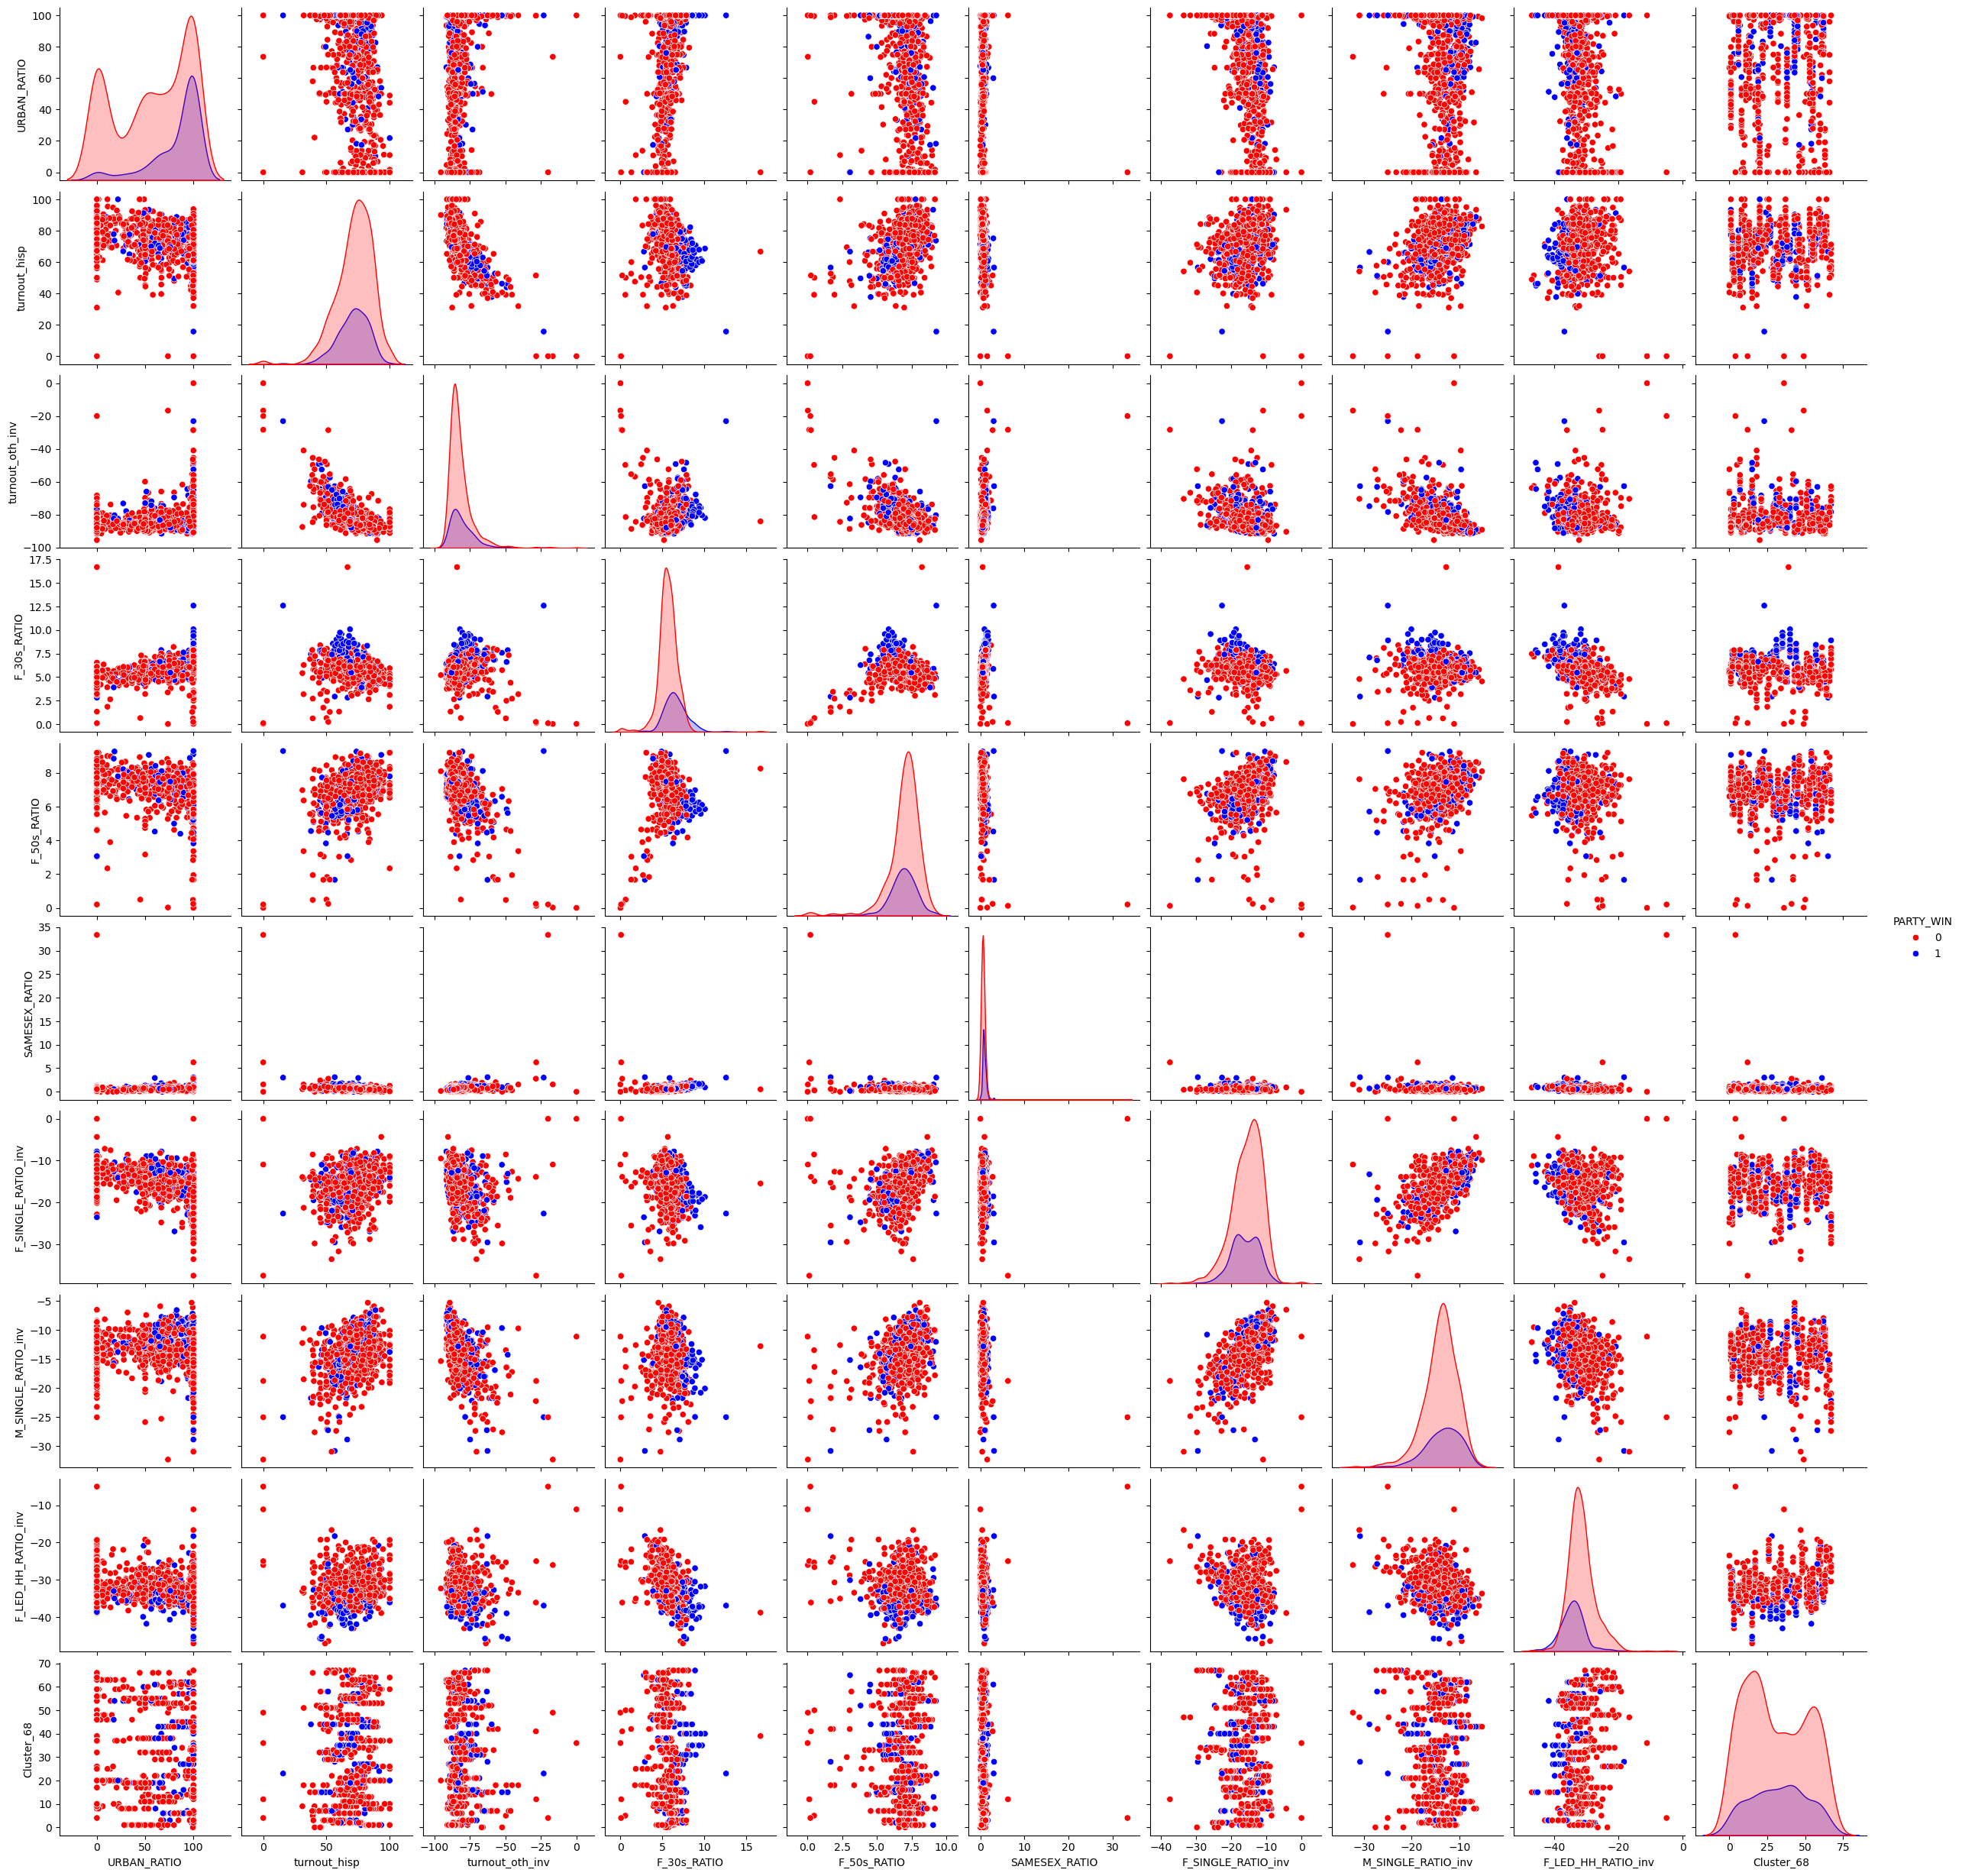

In [23]:
    # Create pairplot with PARTY_WIN hue
sns.pairplot(PA_VOTE_cluster, hue='PARTY_WIN', palette={0: 'red', 1: 'blue'})
plt.show()

In [49]:
# Select significant predictors for logistic regression

initial_vars = ['URBAN_RATIO', 'turnout_hisp', 'turnout_oth_inv', 'F_30s_RATIO', 'F_50s_RATIO', 
                'SAMESEX_RATIO', 'F_SINGLE_RATIO_inv', 'M_SINGLE_RATIO_inv', 'F_LED_HH_RATIO_inv']
PA_VOTE_1 = PA_VOTE_cluster[initial_vars]
y = PA_VOTE_cluster['PARTY_WIN']

# Standardize selected features
scaler = StandardScaler()
trim_1 = scaler.fit_transform(PA_VOTE_1)

# Add constant for intercept
trim_1 = sm.add_constant(trim_1)

# Fit logistic regression model with selected features
logit_1_model = sm.Logit(y, trim_1).fit()

# Display results
logit_1_model.summary()

Optimization terminated successfully.
         Current function value: 0.451001
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              PARTY_WIN   No. Observations:                  963
Model:                          Logit   Df Residuals:                      953
Method:                           MLE   Df Model:                            9
Date:                Fri, 14 Feb 2025   Pseudo R-squ.:                  0.1760
Time:                        23:46:50   Log-Likelihood:                -434.31
converged:                       True   LL-Null:                       -527.07
Covariance Type:            nonrobust   LLR p-value:                 3.587e-35
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5423      0.102    -15.111      0.000      -1.742      -1.342
x1             0.6639      0.148      4.485      0.000       0.374       0.954
x2             0.5456      0.148      3.677      0.000       0.255       0.837
x3             0.1649      0.179      0.923      0.356      -0.185       0.515
x4             0.5233      0.135      3.868      0.000       0.258       0.789
x5             0.0722      0.142      0.509      0.611      -0.206       0.350
x6             0.3940      0.092      4.287      0.000       0.214       0.574
x7            -0.0135      0.160     -0.085      0.932      -0.326       0.299
x8             0.0722      0.153      0.472      0.637      -0.228       0.372
x9            -0.5445      0.155     -3.512      0.000      -0.848      -0.241
==============================================================================
"""

In [ ]:
    Pseudo R² = 0.1760 (Moderate explanatory power)
    Log-Likelihood = -434.31 (Improved from null model: -527.07)
    LLR p-value = 3.587e-35 (Highly significant overall)



In [51]:
# Select significant predictors for logistic regression

final_vars = ['URBAN_RATIO', 'turnout_hisp', 'F_30s_RATIO', 'SAMESEX_RATIO', 'F_LED_HH_RATIO_inv']
PA_VOTE_2 = PA_VOTE_cluster[final_vars]
y = PA_VOTE_cluster['PARTY_WIN']

# Standardize selected features
scaler = StandardScaler()
trim_2 = scaler.fit_transform(PA_VOTE_2)

# Add constant for intercept
trim_2 = sm.add_constant(trim_2)

# Fit logistic regression model with selected features
logit_2_model = sm.Logit(y, trim_2).fit()

# Display results
logit_2_model.summary()

Optimization terminated successfully.
         Current function value: 0.451515
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              PARTY_WIN   No. Observations:                  963
Model:                          Logit   Df Residuals:                      957
Method:                           MLE   Df Model:                            5
Date:                Fri, 14 Feb 2025   Pseudo R-squ.:                  0.1750
Time:                        23:52:43   Log-Likelihood:                -434.81
converged:                       True   LL-Null:                       -527.07
Covariance Type:            nonrobust   LLR p-value:                 5.810e-38
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5428      0.101    -15.203      0.000      -1.742      -1.344
x1             0.6663      0.125      5.342      0.000       0.422       0.911
x2             0.4953      0.109      4.531      0.000       0.281       0.710
x3             0.4933      0.120      4.096      0.000       0.257       0.729
x4             0.4084      0.078      5.212      0.000       0.255       0.562
x5            -0.6010      0.112     -5.351      0.000      -0.821      -0.381
==============================================================================
"""

Pseudo R² = 0.1750 (Slight decrease from 0.1760, but still strong)
Log-Likelihood = -434.81 (Minimal change from -434.31)
LLR p-value = 3.729e-37 (Highly significant)

In [59]:
# Generate predicted probabilities using the updated logit_2_model
pred_2_probs = logit_2_model.predict(trim_2)  # Probabilities
pred_2 = (pred_2_probs > 0.5).astype(int)  # Convert to binary predictions

# Compute accuracy
accuracy_2 = accuracy_score(y, pred_2)
report_2 = classification_report(y, pred_2)
conf_matrix_2 = confusion_matrix(y, pred_2)

# Display results
print(f'Logistic Regression Accuracy: {accuracy_2:.4f}')
print(report_2)
print('Confusion Matrix:')
print(conf_matrix_2)

Logistic Regression Accuracy: 0.7954
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       735
           1       0.67      0.27      0.39       228

    accuracy                           0.80       963
   macro avg       0.74      0.61      0.63       963
weighted avg       0.78      0.80      0.76       963

Confusion Matrix:
[[704  31]
 [166  62]]


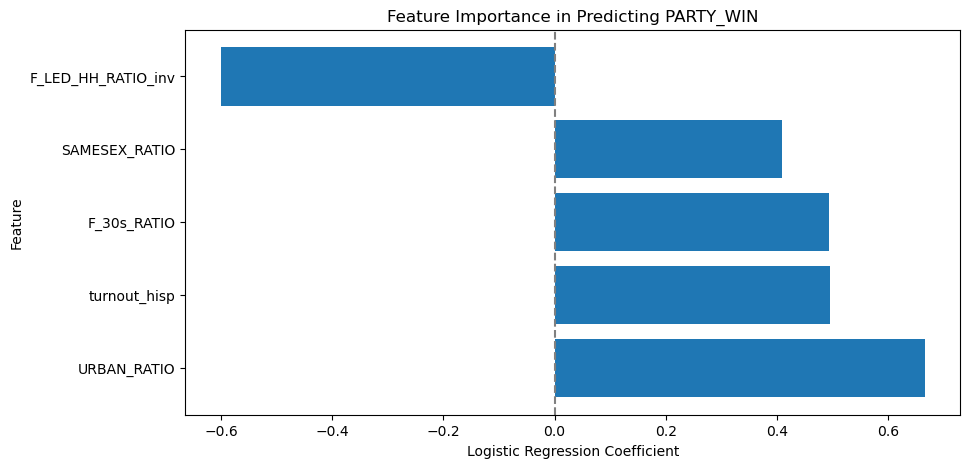

In [55]:
# Extract coefficients
coefs = logit_2_model.params[1:]  # Exclude the constant term
features = final_vars  # Use original feature names

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(final_vars, coefs)
plt.xlabel('Logistic Regression Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting PARTY_WIN')
plt.axvline(x=0, color='gray', linestyle='--')  # Reference line at 0
plt.show()


In [209]:
# Select significant predictors for logistic regression

four_vars = ['F_SINGLE_RATIO_inv', 'M_SINGLE_RATIO_inv', 
              'F_LED_HH_RATIO_inv', 'M_LED_HH_RATIO_inv']
PA_VOTE_04 = PA_VOTE_cluster[four_vars]
y = PA_VOTE_cluster['PARTY_WIN']

# Standardize selected features
scaler = StandardScaler()
trim_4 = scaler.fit_transform(PA_VOTE_04)

# Add constant for intercept
trim_4 = sm.add_constant(trim_4)

# Fit logistic regression model with selected features
logit_4_model = sm.Logit(y, trim_4).fit()

# Display results
logit_4_model.summary()

Optimization terminated successfully.
         Current function value: 0.488136
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              PARTY_WIN   No. Observations:                  963
Model:                          Logit   Df Residuals:                      958
Method:                           MLE   Df Model:                            4
Date:                Fri, 14 Feb 2025   Pseudo R-squ.:                  0.1081
Time:                        19:29:08   Log-Likelihood:                -470.08
converged:                       True   LL-Null:                       -527.07
Covariance Type:            nonrobust   LLR p-value:                 1.029e-23
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3965      0.091    -15.400      0.000      -1.574      -1.219
x1           146.5932     52.198      2.808      0.005      44.287     248.900
x2           125.9778     44.621      2.823      0.005      38.522     213.434
x3           146.4162     52.281      2.801      0.005      43.946     248.886
x4           241.3314     85.622      2.819      0.005      73.515     409.148
==============================================================================
"""

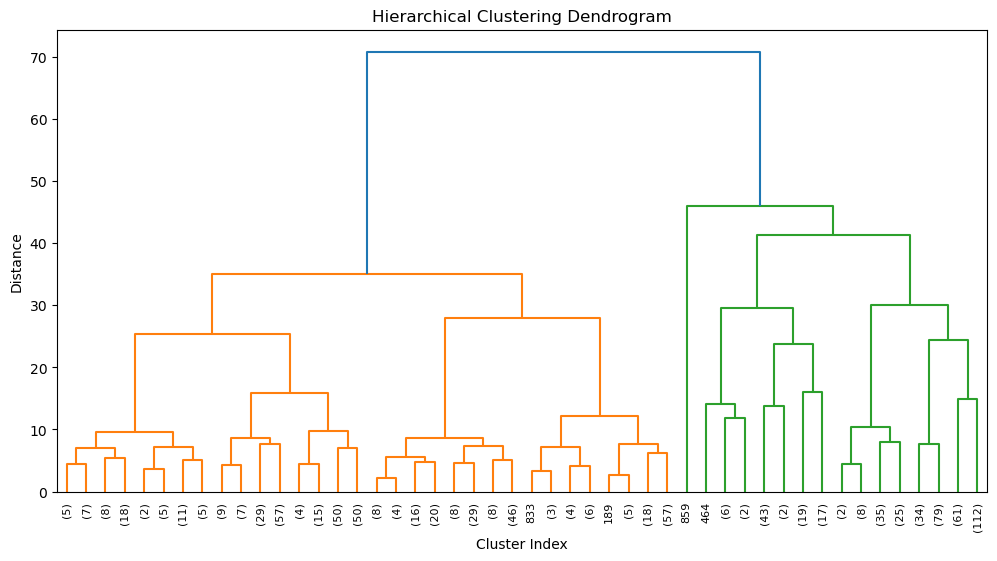

In [102]:
# Standardize features for hierarchical clustering
PA_VOTE_hier = StandardScaler().fit_transform(PA_VOTE_D.drop(columns=['PARTY_WIN']))

# Compute linkage matrix
linkage_matrix = linkage(PA_VOTE_hier, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
plt.show()


Clustering may not work for this dataset, with such popular cities, it does take a lot of rural areas to equal a single record from Philly or Pittsburg.

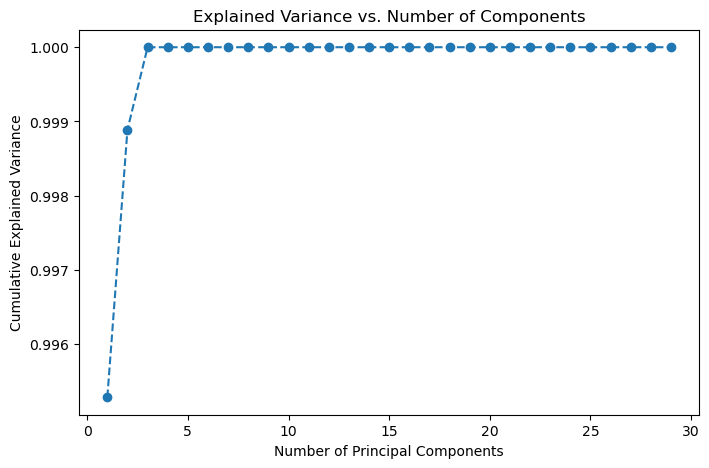

In [406]:
    # Apply PCA on the standardized dataset
pca = PCA()
PA_VOTE_PCA = pca.fit_transform(PA_VOTE_scaled)

    # Plot explained variance to determine optimal number of components
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()


Some domains naturally have low intrinsic dimensionality (like voter demographics).If the dataset has inherently low dimensionality (e.g., strong correlations between features), then only a few PCs should matter.

In [219]:

# Compute VIF for housing variables
X_housing = PA_VOTE_cluster[['F_SINGLE_RATIO_inv', 'M_SINGLE_RATIO_inv', 
                             'F_LED_HH_RATIO_inv', 'M_LED_HH_RATIO_inv']]
X_housing = sm.add_constant(X_housing)  # Add constant for proper VIF calculation

vif_data = pd.DataFrame()
vif_data['Feature'] = X_housing.columns
vif_data['VIF'] = [variance_inflation_factor(X_housing.values, i) for i in range(X_housing.shape[1])]

print(vif_data)

              Feature           VIF
0               const  2.298213e+08
1  F_SINGLE_RATIO_inv  4.138392e+05
2  M_SINGLE_RATIO_inv  3.024061e+05
3  F_LED_HH_RATIO_inv  4.152571e+05
4  M_LED_HH_RATIO_inv  1.113493e+06


In [432]:

    # Refine remaining features in DF
manova_features = [col for col in PA_VOTE_F.columns if col not in ['HAC_Cluster', 'PARTY_WIN']]

    # Run MANOVA 
manova_model = MANOVA.from_formula(" + ".join(manova_features) + " ~ HAC_Cluster", data=PA_VOTE_F)
print(manova_model.mv_test())

                         Multivariate linear model
                                                                           
---------------------------------------------------------------------------
       Intercept           Value      Num DF  Den DF     F Value     Pr > F
---------------------------------------------------------------------------
          Wilks' lambda       0.0000 22.0000 940.0000 414108452.2186 0.0000
         Pillai's trace       1.0000 22.0000 940.0000 414108452.2186 0.0000
 Hotelling-Lawley trace 9691899.9455 22.0000 940.0000 414108452.2186 0.0000
    Roy's greatest root 9691899.9455 22.0000 940.0000 414108452.2186 0.0000
---------------------------------------------------------------------------
                                                                           
-----------------------------------------------------------------------------
           HAC_Cluster         Value     Num DF    Den DF    F Value   Pr > F
---------------------------------

In [446]:
# Check significance of individual features using ANOVA
anova_results = {}
for feature in manova_features:
    model = ols(f"{feature} ~ HAC_Cluster", data=PA_VOTE_F).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_results[feature] = anova_table["PR(>F)"].iloc[0]  # Extract p-value

# Sort features by significance (lowest p-values first)
sorted_features = sorted(anova_results.items(), key=lambda x: x[1])

# Select the top 3 most significant features
top_3_features = [sorted_features[i][0] for i in range(3)]
print("Top 3 Features Selected:", top_3_features)
#Top 5 Features Selected: ['voted_all', 'OTH_VOTES', 'M_SINGLE_RATIO', 'F_SINGLE_RATIO', 'M_LED_HH_RATIO']

Top 3 Features Selected: ['voted_all', 'OTH_VOTES', 'M_SINGLE_RATIO']


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.manova import MANOVA


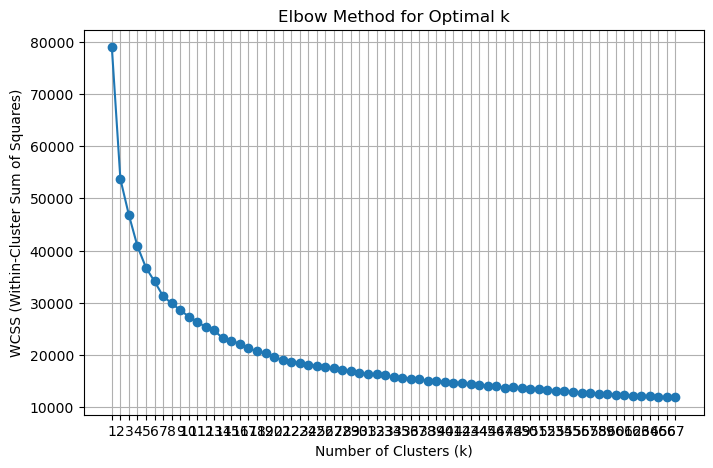

In [171]:

# Standardize the data for K-Means
X_kmeans = StandardScaler().fit_transform(PA_VOTE_C.drop(columns=['PARTY_WIN']))

# Compute WCSS for a range of clusters
wcss = []
k_range = range(1, 68)  # Testing k from 1 to 14

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=630, n_init=10)
    kmeans.fit(X_kmeans)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid()
plt.show()


In [ ]:
# Normalize by total votes to adjust for urban vs. rural imbalance
PA_VOTE_E['weighted_turnout'] = PA_VOTE_E['voted_all'] / PA_VOTE_E['OTH_VOTES']

# Apply log transformation to compress large variations
PA_VOTE_E['log_voted_all'] = np.log1p(PA_VOTE_E['voted_all'])
PA_VOTE_E['log_OTH_VOTES'] = np.log1p(PA_VOTE_E['OTH_VOTES'])

# Select features for clustering
features_for_clustering = ['log_voted_all', 'log_OTH_VOTES', 'M_SINGLE_RATIO', 'weighted_turnout']

# Standardize data
scaler = StandardScaler()
PA_VOTE_scaled = scaler.fit_transform(PA_VOTE_E[features_for_clustering])

# Compute linkage using Ward’s method
linkage_weighted = linkage(PA_VOTE_scaled, method='ward')

# Plot dendrogram to determine optimal cutoff
plt.figure(figsize=(12, 6))
dendrogram(linkage_weighted, truncate_mode='level', p=10)
plt.axhline(y=8, color='r', linestyle='--')  # Adjust cutoff manually
plt.title("Dendrogram with Distance Cutoff")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

# Set optimal cluster number
optimal_k = 5  # Adjust based on dendrogram
clusters_weighted = fcluster(linkage_weighted, optimal_k, criterion='maxclust')

# Add clusters to DataFrame
PA_VOTE_E['HAC_Cluster_Weighted'] = clusters_weighted

# Display cluster distribution
print(PA_VOTE_E['HAC_Cluster_Weighted'].value_counts().sort_index())

In [215]:
 # Will list all open dataframes in notebook
dfs = [var for var in globals() if isinstance(globals()[var], pd.DataFrame)]
dfs 

['PA_VOTE_C',
 'corr_matrix',
 'upper_tri',
 'PA_VOTE_cluster',
 'cluster_distro',
 'cluster_d',
 'PA_VOTE_clust68',
 'clust68_distro',
 'PA_13_clust',
 'PA_68_clust',
 'PA_VOTE_D13',
 'PA_VOTE_D68',
 'PA_VOTE_D10',
 'PA_VOTE_D11',
 'PA_VOTE_09',
 'PA_VOTE_04']

In [ ]:
    # delete multiple df's delete one:(  del df_1  )
for df_name in ['PA_VOTE_X', 'PA_VOTE_Y']:
    if df_name in globals():  # Check if the variable exists
        del globals()[df_name]

import gc
gc.collect()

In [9]:

#selected_columns = ['JOIN', 'turnout_all', 'DEM_VOTES', 'REP_VOTES', 
#    'OTH_VOTES', 'TOTAL_VOTES']
#print(PA_VOTE_B[selected_columns])
#print(PA_VOTE_C.info())
#print(PA_VOTE_C.head(20))
# Display rows where any 'reg_' column has NaN or zero values
#filtered_df = (PA_VOTE_C[['DEM_SHARE', 'REP_SHARE', 'OTH_SHARE']] == 0).any(axis=1)
#| (PA_VOTE_C[['DEM_SHARE', 'REP_SHARE', 'OTH_SHARE']] == 0).any(axis=1)]

#print(PA_VOTE_DF[['GEOID-5_x', 'GEOID-5_y']])
#PA_VOTE_D.to_excel('PA_VOTE_D.xlsx', index=False)
PA_VOTE_cluster = pd.read_excel('PA_VOTE_C_final.xlsx')
#print(PA_VOTE_D['PARTY_WIN'].value_counts(dropna=False))

#pd.set_option('display.max_columns', None)
print(PA_VOTE_cluster.info())
#print(cluster_distro.info())

FileNotFoundError: [Errno 2] No such file or directory: 'PA_VOTE_C.xlsx'